In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Laad data met features
df = pd.read_csv('../data/processed/transactions_with_features.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("="*60)
print("DATA LOADED FOR ML MODEL")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Transactions: {len(df)}")
print(f"\nColumns: {len(df.columns)}")

DATA LOADED FOR ML MODEL
Shape: (1631, 60)
Transactions: 1631

Columns: 60


In [2]:
print("="*60)
print("CREATING CATEGORY LABELS FROM KEYWORDS")
print("="*60)

# Vind alle keyword kolommen
keyword_cols = [col for col in df.columns if col.startswith('Has_')]
print(f"Keyword columns found: {len(keyword_cols)}")

# Maak een 'Category' kolom gebaseerd op keywords
def assign_category(row):
    """Assign category based on keyword matches"""
    for col in keyword_cols:
        if row[col] == 1:
            # Return eerste match (je kunt dit aanpassen voor prioriteit)
            return col.replace('Has_', '')
    return 'other'  # Als geen keyword match

df['Category'] = df.apply(assign_category, axis=1)

print("\n✅ Categories assigned!")

# Toon categorie verdeling
print("\n" + "="*60)
print("CATEGORY DISTRIBUTION")
print("="*60)
category_counts = df['Category'].value_counts()
print(category_counts)

print(f"\nTotal categories: {df['Category'].nunique()}")
print(f"Transactions with 'other': {(df['Category'] == 'other').sum()} ({(df['Category'] == 'other').mean()*100:.1f}%)")

CREATING CATEGORY LABELS FROM KEYWORDS
Keyword columns found: 25

✅ Categories assigned!

CATEGORY DISTRIBUTION
Category
supermarket      266
bar_cafe         220
transport        169
restaurant       163
online           153
transfer         146
Gambling         144
saving           126
other_shops       62
salary            44
health            27
subscription      25
fitness           13
taxes             13
rent              12
Uncle DUO         12
tickets           10
atm                8
personal care      4
Goodwill           4
insurance          4
clothing           3
booking            2
free time          1
Name: count, dtype: int64

Total categories: 24
Transactions with 'other': 0 (0.0%)


In [3]:
print("="*60)
print("PREPARING DATA FOR MODEL TRAINING")
print("="*60)

# Filter alleen transacties met een categorie (niet 'other')
df_labeled = df[df['Category'] != 'other'].copy()

print(f"Original data: {len(df)} transactions")
print(f"Labeled data: {len(df_labeled)} transactions")
print(f"Removed 'other': {len(df) - len(df_labeled)} transactions")

# Combineer text features voor het model
df_labeled['Text_Features'] = (
    df_labeled['Counterparty'].fillna('') + ' ' + 
    df_labeled['Description_Full'].fillna('')
).str.strip()

# Check of we genoeg data hebben
print(f"\n" + "="*60)
print("CHECKING DATA SUFFICIENCY")
print("="*60)
min_samples_per_category = df_labeled['Category'].value_counts().min()
print(f"Smallest category has: {min_samples_per_category} samples")

if len(df_labeled) < 50:
    print("\n⚠️ WARNING: Not enough labeled data for ML model!")
    print("We need at least 50 labeled transactions.")
    print("Please add more keywords in Step 3 to label more transactions.")
else:
    print(f"\n✅ Sufficient data for training! ({len(df_labeled)} samples)")

PREPARING DATA FOR MODEL TRAINING
Original data: 1631 transactions
Labeled data: 1631 transactions
Removed 'other': 0 transactions

CHECKING DATA SUFFICIENCY
Smallest category has: 1 samples

✅ Sufficient data for training! (1631 samples)


In [5]:
print("="*60)
print("SPLITTING DATA INTO TRAIN/TEST SETS")
print("="*60)

# Features (X) en labels (y)
X = df_labeled['Text_Features']
y = df_labeled['Category']

# Check category counts
print("Category counts:")
category_counts = y.value_counts()
print(category_counts)

# Filter out categories with only 1 sample (te weinig voor stratify)
min_samples = 2
categories_to_keep = category_counts[category_counts >= min_samples].index

print(f"\n" + "="*60)
print(f"FILTERING CATEGORIES")
print(f"="*60)
print(f"Categories with < {min_samples} samples: {len(category_counts[category_counts < min_samples])}")
print(f"Categories to keep: {len(categories_to_keep)}")

# Filter data
mask = y.isin(categories_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]

print(f"\nOriginal labeled data: {len(y)} samples")
print(f"Filtered data: {len(y_filtered)} samples")
print(f"Removed: {len(y) - len(y_filtered)} samples")

# Check if we have enough data
if len(y_filtered) < 20:
    print("\n⚠️ WARNING: Not enough data after filtering!")
    print("Please add more keywords in Step 3 to label more transactions.")
    print("\nWe'll continue without stratify for now...")
    
    # Train/test split WITHOUT stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, 
        test_size=0.2, 
        random_state=42
    )
else:
    # Train/test split WITH stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, 
        test_size=0.2, 
        random_state=42,
        stratify=y_filtered
    )
    print("\n✅ Stratified split successful!")

print(f"\n" + "="*60)
print(f"TRAIN/TEST SPLIT COMPLETE")
print(f"="*60)
print(f"Training set: {len(X_train)} samples")
print(f"Test set:     {len(X_test)} samples")

print("\nTraining set category distribution:")
print(y_train.value_counts())

print("\nTest set category distribution:")
print(y_test.value_counts())

SPLITTING DATA INTO TRAIN/TEST SETS
Category counts:
Category
supermarket      266
bar_cafe         220
transport        169
restaurant       163
online           153
transfer         146
Gambling         144
saving           126
other_shops       62
salary            44
health            27
subscription      25
fitness           13
taxes             13
rent              12
Uncle DUO         12
tickets           10
atm                8
personal care      4
Goodwill           4
insurance          4
clothing           3
booking            2
free time          1
Name: count, dtype: int64

FILTERING CATEGORIES
Categories with < 2 samples: 1
Categories to keep: 23

Original labeled data: 1631 samples
Filtered data: 1630 samples
Removed: 1 samples

✅ Stratified split successful!

TRAIN/TEST SPLIT COMPLETE
Training set: 1304 samples
Test set:     326 samples

Training set category distribution:
Category
supermarket      213
bar_cafe         176
transport        135
restaurant       131
online

In [6]:
print("="*60)
print("CONVERTING TEXT TO NUMERICAL FEATURES (TF-IDF)")
print("="*60)

# TF-IDF Vectorizer
# Dit converteert text naar numbers die ML modellen kunnen gebruiken
vectorizer = TfidfVectorizer(
    max_features=100,  # Top 100 belangrijkste woorden
    ngram_range=(1, 2),  # Gebruik zowel enkele woorden als woordparen
    min_df=2  # Woord moet minimaal 2x voorkomen
)

# Fit en transform training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform test data (gebruik dezelfde vectorizer!)
X_test_tfidf = vectorizer.transform(X_test)

print(f"✅ Text vectorization complete!")
print(f"\nTraining features shape: {X_train_tfidf.shape}")
print(f"Test features shape:     {X_test_tfidf.shape}")

# Toon top features (belangrijkste woorden)
feature_names = vectorizer.get_feature_names_out()
print(f"\nTop 20 features (words):")
print(list(feature_names[:20]))

CONVERTING TEXT TO NUMERICAL FEATURES (TF-IDF)
✅ Text vectorization complete!

Training features shape: (1304, 100)
Test features shape:     (326, 100)

Top 20 features (words):
['00', '01', '02', '041', '041 terminal', '05', '10', '11', '116477897', '116477897 xui', '12', '13', '1382', '1382 breda', '14', '15', '16', '17', '18', '19']


In [7]:
print("="*60)
print("TRAINING RANDOM FOREST CLASSIFIER")
print("="*60)

# Random Forest model
model = RandomForestClassifier(
    n_estimators=100,  # 100 decision trees
    max_depth=10,
    random_state=42,
    n_jobs=-1  # Gebruik alle CPU cores
)

print("Training model...")
model.fit(X_train_tfidf, y_train)

print("✅ Model trained!")

# Predictions op test set
y_pred = model.predict(X_test_tfidf)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Test Accuracy: {accuracy*100:.2f}%")

TRAINING RANDOM FOREST CLASSIFIER
Training model...
✅ Model trained!

🎯 Test Accuracy: 72.09%


MODEL EVALUATION

Classification Report:
               precision    recall  f1-score   support

     Gambling       0.97      0.97      0.97        29
     Goodwill       0.00      0.00      0.00         1
    Uncle DUO       0.00      0.00      0.00         2
          atm       0.00      0.00      0.00         2
     bar_cafe       0.52      0.86      0.65        44
     clothing       0.00      0.00      0.00         1
      fitness       0.00      0.00      0.00         3
       health       0.00      0.00      0.00         5
    insurance       0.00      0.00      0.00         1
       online       0.66      0.94      0.77        31
  other_shops       0.00      0.00      0.00        12
personal care       0.00      0.00      0.00         1
         rent       1.00      1.00      1.00         2
   restaurant       0.92      0.38      0.53        32
       salary       0.67      0.44      0.53         9
       saving       0.50      1.00      0.67        25
 subscription       0.0

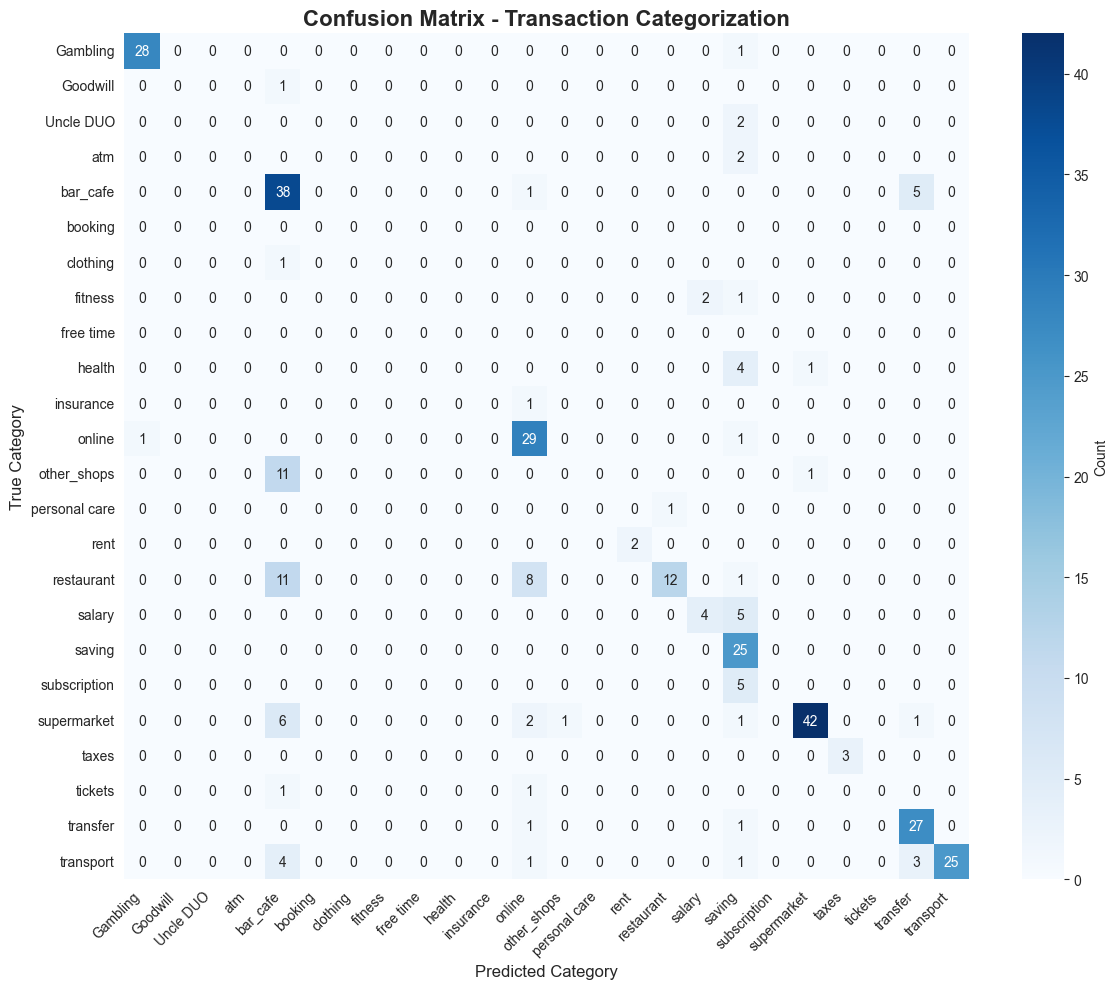

In [8]:
print("="*60)
print("MODEL EVALUATION")
print("="*60)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Get unique categories
categories = sorted(df_labeled['Category'].unique())

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=categories)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, 
            yticklabels=categories,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Transaction Categorization', fontsize=16, fontweight='bold')
plt.ylabel('True Category', fontsize=12)
plt.xlabel('Predicted Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../visualizations/03_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✅ Confusion matrix saved: visualizations/03_confusion_matrix.png")
plt.show()

FEATURE IMPORTANCE
Top 20 most important features (words):
            feature  importance
50         croymans    0.053133
46             cafe    0.030055
30  6xxxx8048 pasnr    0.028063
57       google pay    0.026942
25       4817lr nld    0.024810
24           4817lr    0.024507
68      matheeuwsen    0.021622
56           google    0.021044
79              pas    0.020539
58            heijn    0.019852
8         116477897    0.019788
33           albert    0.019335
35             appr    0.019099
55          erp erp    0.019024
91             toto    0.018909
53              erp    0.018471
83              pay    0.018373
36          appr cd    0.018113
95              van    0.016877
34     albert heijn    0.016860

✅ Feature importance saved: visualizations/04_feature_importance.png


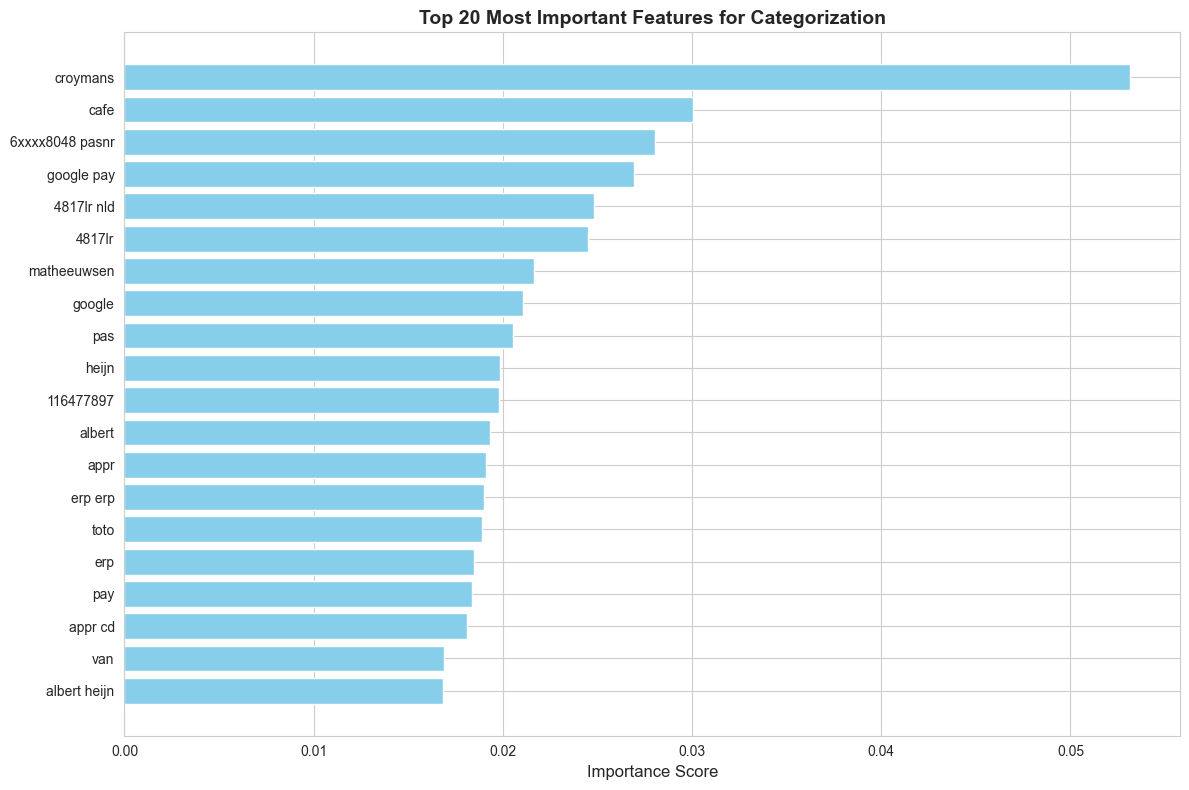

In [9]:
print("="*60)
print("FEATURE IMPORTANCE")
print("="*60)

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

print("Top 20 most important features (words):")
print(feature_importance)

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'].values, color='skyblue')
plt.yticks(range(len(feature_importance)), feature_importance['feature'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Most Important Features for Categorization', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../visualizations/04_feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✅ Feature importance saved: visualizations/04_feature_importance.png")
plt.show()

In [10]:
print("="*60)
print("TESTING PREDICTIONS ON NEW TRANSACTIONS")
print("="*60)

# Test op een paar voorbeelden uit test set
sample_indices = np.random.choice(X_test.index, size=10, replace=False)

print("Sample predictions:\n")
for idx in sample_indices:
    text = X_test.loc[idx]
    true_label = y_test.loc[idx]
    
    # Predict
    text_tfidf = vectorizer.transform([text])
    pred_label = model.predict(text_tfidf)[0]
    
    # Get prediction probability
    pred_proba = model.predict_proba(text_tfidf)[0]
    confidence = max(pred_proba) * 100
    
    print(f"Text: {text[:60]}")
    print(f"  True:       {true_label}")
    print(f"  Predicted:  {pred_label} (confidence: {confidence:.1f}%)")
    print(f"  {'✅ CORRECT' if true_label == pred_label else '❌ WRONG'}\n")

TESTING PREDICTIONS ON NEW TRANSACTIONS
Sample predictions:

Text: Albert Heijn 1382 BREDA, 4817LR, NLD, 16:20 . Pas: 6xxxx8048
  True:       supermarket
  Predicted:  supermarket (confidence: 100.0%)
  ✅ CORRECT

Text: Cafe-Party van Haandel ERP, 5469BJ, NLD, 19:03 . Pas: 6xxxx8
  True:       restaurant
  Predicted:  restaurant (confidence: 74.0%)
  ✅ CORRECT

Text: CCV*Cafe-zaal De Paal ERP, 5469CE, NLD, 00:00 . Pas: 6xxxx80
  True:       restaurant
  Predicted:  restaurant (confidence: 43.7%)
  ✅ CORRECT

Text: Kantine ERP, 5469CG, NLD, 15:40 . Pas: 6xxxx8048 pasnr. 041 
  True:       bar_cafe
  Predicted:  bar_cafe (confidence: 99.4%)
  ✅ CORRECT

Text: Johan Cruijff ArenA Amsterdam, 1101AX, NLD, 23:06 . Pas: 6xx
  True:       bar_cafe
  Predicted:  bar_cafe (confidence: 33.9%)
  ✅ CORRECT

Text: Caelum Supermarkt Erp ERP, 5469BS, NLD, 21:26 . Pas: 6xxxx80
  True:       supermarket
  Predicted:  supermarket (confidence: 99.8%)
  ✅ CORRECT

Text: Job Verbrugge via Rabo Betaalverzoek

In [11]:
import pickle

print("="*60)
print("SAVING MODEL AND VECTORIZER")
print("="*60)

# Save model
with open('../data/models/category_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✅ Model saved: data/models/category_model.pkl")

# Save vectorizer
with open('../data/models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("✅ Vectorizer saved: data/models/tfidf_vectorizer.pkl")

# Save label encoder info
categories_list = list(model.classes_)
with open('../data/models/categories.pkl', 'wb') as f:
    pickle.dump(categories_list, f)
print("✅ Categories saved: data/models/categories.pkl")

print(f"\n📊 MODEL SUMMARY:")
print(f"  Accuracy: {accuracy*100:.2f}%")
print(f"  Categories: {len(categories_list)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")

print("\n✅ STEP 4 COMPLETE!")

SAVING MODEL AND VECTORIZER
✅ Model saved: data/models/category_model.pkl
✅ Vectorizer saved: data/models/tfidf_vectorizer.pkl
✅ Categories saved: data/models/categories.pkl

📊 MODEL SUMMARY:
  Accuracy: 72.09%
  Categories: 23
  Training samples: 1304
  Test samples: 326

✅ STEP 4 COMPLETE!
